# week6_hw PCA and K-means

In [1]:
import jieba
import os
import pandas as pd
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import timedelta, date
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA as PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.offline as offline
#import plotly.graph_objs as go
#init_notebook_mode(connected=True)

In [3]:
def is_chinese(uchar):         
    if u'\u4e00' <= uchar<=u'\u9fff':
        return True
    else:
        return False

In [4]:
# 專有名詞
jieba.load_userdict('ProperN.txt')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/bf/kxrhqhkd3s1263kmtf84x8zw0000gn/T/jieba.cache
Loading model cost 0.747 seconds.
Prefix dict has been built succesfully.


In [5]:
folders = ["中電/", "金雨/", "大同/", "中興電/", "聲寶/", "東元/", "永大/", "亞力/"]

In [6]:
imp_words = ["經營權",  "董事會",  "請辭", "接任", "出任", "兼任", "辭去", "入主", "推選", "另聘", "市場派", "公司派"]

In [7]:
def get_txts(folder):
    all_files = []
    for f in os.listdir("News/" + folder):
        if not f.startswith('.'):
            all_files.append(f)
    #os.listdir("News/" + folder)   # imagine you're one directory above test dir
    return all_files

In [8]:
with open("StopWords.txt") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
stopwords = [x.strip() for x in content]

In [9]:
def get_word_dict(filter_list, word_dict):
    word_dict_local = word_dict
    copy_list = filter_list.copy()
    for w in copy_list:
        if (w not in stopwords) :
            if w in word_dict_local:
                word_dict_local[w] = word_dict_local[w] + 1
            else:
                word_dict_local[w] = 1
    return word_dict_local

In [10]:
# 讀取新聞檔案，並使用jieba切詞
def textMining(folder, file):
    with open("./News/" + folder + file, 'rt',encoding="utf-8", errors='ignore') as txt:
        data = txt.read()
    #text segmentation
    seg_list = jieba.cut(data, cut_all=False)
    seg_list = list(seg_list)
    filter_list = []
    jump = False
    for word in seg_list:
        for s in word:
            if not is_chinese(s):
                jump = True
                break
        if not jump:
            filter_list.append(word)
        jump = False
    return filter_list

In [11]:
def analyze(folder, corpus, txts_in_folder):
    # tfidf
    vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 0.2)
    tfidf = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    print("tfidf.shape: ", tfidf.shape)
    for i in range(len(corpus)):
        print('----{0} NEWS----'.format(txts_in_folder[i]))
        for j in range(len(words)):
            if words[j] in imp_words:
                tfidf[i,j] = tfidf[i,j] * 2
            if tfidf[i,j] > 0.2:
                print(words[j], tfidf[i,j], i ,j)
    
    X = tfidf.toarray()
    sklearn_pca = PCA(n_components = 2)
    Y_sklearn = sklearn_pca.fit_transform(X)
    
    return Y_sklearn

In [12]:
def plot_cloud(wordDict):
    font = r"/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf"
    wordcloud = WordCloud(width=2000, height=1000, margin=2 , font_path=font)
    wordcloud.fit_words(wordDict)
    plt.figure(figsize = (12, 10))
    plt.grid(False)
    plt.imshow(wordcloud)

In [13]:
def plot_bar(wordDict):
    items = sorted(wordDict.items(), key = lambda x: x[1], reverse = True)[:10]
    keys = dict(items).keys() #top10_key
    print(keys)
    value = dict(items).values() #top10_value
    print(value)
    plt.figure(figsize = (10, 6))
    plt.bar(range(0,10), value)
    plt.xticks(range(0,10), keys, fontsize = 12)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title("Top 10", fontsize = 20)
    plt.show()

In [14]:
def plot_cpa_scatter(Y_sklearn, txts_in_folder):
    pca_data = [
        go.Scatter(
            x = Y_sklearn[:,0],
            y = Y_sklearn[:,1],
            mode = "markers",
            hoverinfo = 'text',
            text = txts_in_folder
        )
    ]

    fig = go.Figure(data = pca_data)
    return py.iplot(fig, filename = 'PCA Scatter Chart')

In [15]:
def plot_kmeans_scatter(Y_sklearn, txts_in_folder):
    kmeans = KMeans(n_clusters = 3)
    X_clustered = kmeans.fit_predict(Y_sklearn)
    
    #Define our own color map
    #LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b', 3: 'y'}
    #label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

    # Plot the scatter digram
    #plt.figure(figsize = (7,7))
    #plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c= label_color, alpha=0.5) 
    #plt.show()
    
    #Define our own color map
    LABEL_COLOR_MAP = {0:'red', 1: 'green', 2: 'blue'}
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]
    
    pca_data = [
        go.Scatter(
            x = Y_sklearn[:,0],
            y = Y_sklearn[:,1],
            mode = "markers",
            hoverinfo = 'text',
            text = txts_in_folder,
            marker = dict(color = label_color)
        )
    ]

    fig = go.Figure(data = pca_data)
    return py.iplot(fig, filename = txts_in_folder[0])

###  分析中電

dict_keys(['照明', '智慧', '產品', '節能', '建築', '開發', '台灣', '產業', '環境', '中國'])
dict_values([109, 34, 31, 28, 25, 23, 20, 18, 17, 16])


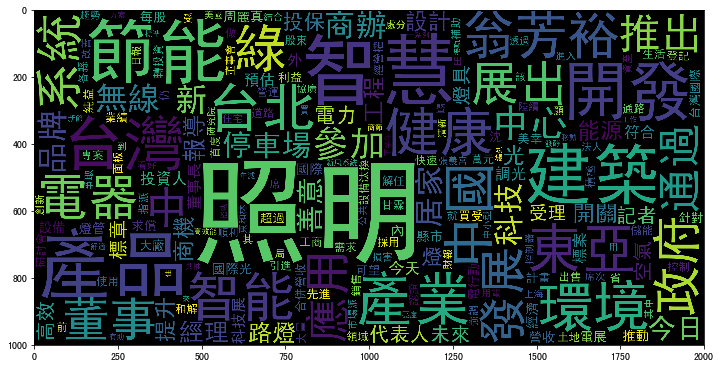

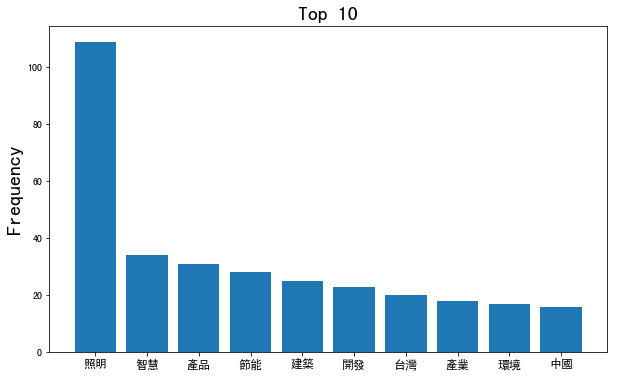

tfidf.shape:  (16, 100)
----20170303_1611_投保中心受理中電求償登記.txt NEWS----
利益 0.4729411124893359 0 11
市場 0.7459663196865982 0 29
指出 0.32552613792342705 0 35
符合 0.20069096455421243 0 67
資訊 0.21708295112169412 0 86
----20170327_1611_中電董事會決議出售台南樹谷廠土地.txt NEWS----
中國 0.27218801583609625 1 0
億元 0.47511160354472964 1 6
出售 0.34513328448895936 1 10
利益 0.34513328448895936 1 11
去年 0.2092592225249102 1 13
通過 0.3168367052415047 1 89
電器 0.29291228837888134 1 95
----20170412_1611_中電參加台灣科技展.txt NEWS----
中國 0.23718641370856203 2 0
今日 0.20050093130891167 2 4
參加 0.2552456800801645 2 14
展出 0.27609357310103627 2 26
智慧 0.2858743140627039 2 43
科技展 0.27609357310103627 2 65
系統 0.368124764134715 2 69
路燈 0.368124764134715 2 88
電力 0.20050093130891167 2 94
電器 0.2552456800801645 2 95
----20170628_1611_現任董座周麗真續掌中電經營權.txt NEWS----
今年 0.39047854748945443 3 3
去年 0.2204422341726571 3 13
市場 0.43010100297100917 3 29
科技 0.2674769919560931 3 64
股東 0.3635775350882644 3 74
----20170628_1611_電纜股市場派遭解任.txt NEWS----
今天 0.2997074068115

In [16]:
# get corpus from folder 中電
txts_in_folder0 = get_txts(folders[0])
word_dict0 = {}
corpus0 = []

for file_name in txts_in_folder0:
    filter_list = textMining(folders[0], file_name)
    word_dict0 = get_word_dict(filter_list, word_dict0)
    join_list = " ".join(filter_list)
    corpus0.append(join_list)

plot_cloud(word_dict0)
plot_bar(word_dict0)

Y_sklearn0 = analyze(folders[0], corpus0, txts_in_folder0)

In [17]:
#plot_cpa_scatter(Y_sklearn0, txts_in_folder0)

In [18]:
plot_kmeans_scatter(Y_sklearn0, txts_in_folder0)

### 分析金雨

dict_keys(['卓燦然', '董事長', '自動', '販賣機', '卓政懋', '兄弟', '越南', '中心', '投資人', '經理'])
dict_values([25, 20, 19, 19, 18, 18, 14, 13, 13, 11])


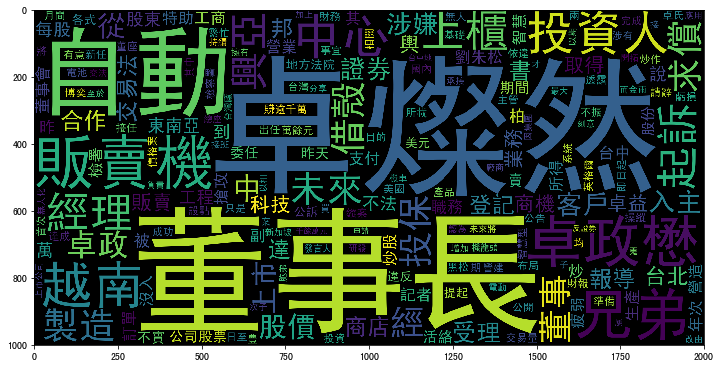

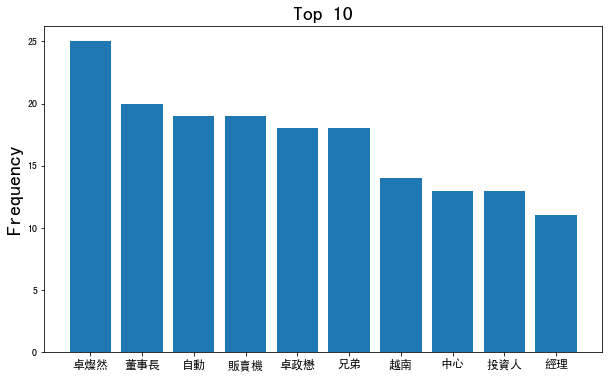

tfidf.shape:  (8, 188)
----20180223_4503_金雨世代交替.txt NEWS----
卓政 0.22552131105739137 0 36
接任 0.2384611510870755 0 85
業務 0.2384611510870755 0 111
自動 0.2794753710717904 0 158
董事長 0.22227007050236802 0 164
販賣機 0.23955031806153457 0 177
----20180412_4503_借殼上市入主金雨.txt NEWS----
上市 0.26281115208753564 1 0
上櫃 0.24364879813968074 1 2
借殼 0.26281115208753564 1 20
兄弟 0.5256223041750713 1 24
入主 0.4872975962793615 1 25
持股 0.21024892167002848 1 84
----20180412_4503_炒作金雨企業股票遭訴.txt NEWS----
上櫃 0.4502245863998873 2 2
交易 0.22200393006575206 2 11
兄弟 0.22200393006575206 2 24
卓燦然 0.3445950316321042 2 38
興亞 0.27750491258219007 2 160
----20180413_4503_金雨前董座涉炒股.txt NEWS----
兄弟 0.30751066753863343 3 24
入主 0.5345421320056144 3 25
卓燦然 0.417653944929095 3 38
董事會 0.30751066753863343 3 163
起訴 0.23865939710234 3 178
----20180530_4503_受理金雨股價操縱案.txt NEWS----
中心 0.29183570161946526 4 7
交易 0.2218997055946689 4 11
交易法 0.2218997055946689 4 12
台北 0.25715041079041717 4 49
投保 0.3214380134880215 4 80
投資人 0.243196418016221 4 82


/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [19]:
# get corpus from folder 金雨
txts_in_folder1 = get_txts(folders[1])
word_dict1 = {}
corpus1 = []

for file_name in txts_in_folder1:
    filter_list = textMining(folders[1], file_name)
    word_dict1 = get_word_dict(filter_list, word_dict1)
    join_list = " ".join(filter_list)
    corpus1.append(join_list)

plot_cloud(word_dict1)
plot_bar(word_dict1)

Y_sklearn1 = analyze(folders[1], corpus1, txts_in_folder1)

In [20]:
plot_kmeans_scatter(Y_sklearn1, txts_in_folder1)

### 分析大同

dict_keys(['股東', '市場派', '林蔚山', '掩埋', '建置', '台電', '太陽能', '郭文艷', '開發', '董事長'])
dict_values([22, 19, 14, 12, 12, 12, 11, 11, 10, 10])


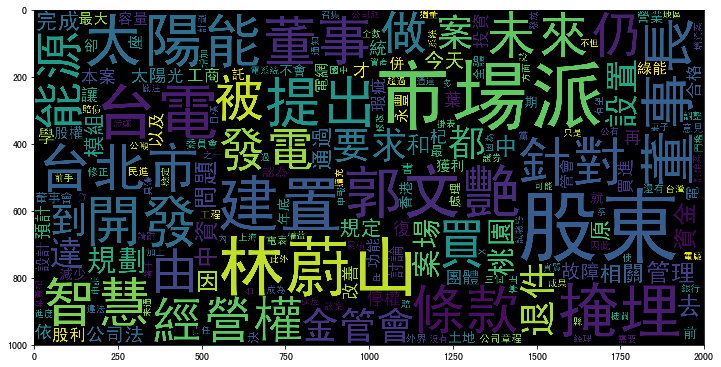

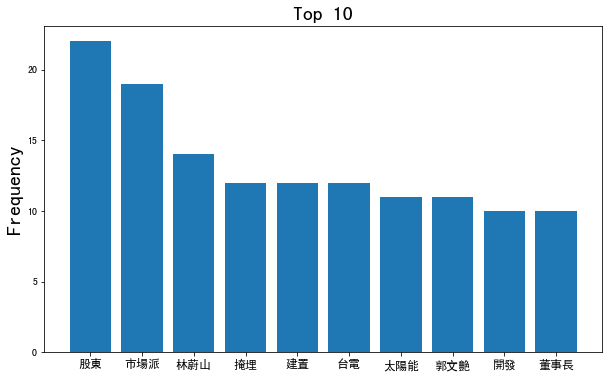

tfidf.shape:  (9, 187)
----237120180313.txt NEWS----
大同 0.2496702058480557 0 55
建置 0.29868970491248076 0 69
掩埋 0.5475977923395481 0 83
智慧 0.34847132239789425 0 94
桃園 0.24890808742706733 0 100
能源 0.24890808742706733 0 136
----237120180324.txt NEWS----
中資 0.2209594011313051 1 5
億元 0.2209594011313051 1 17
大同 0.4142269901493455 1 55
經營權 0.2928444892162521 1 127
股票 0.5082616148513762 1 134
金管會 0.3176635092821102 1 176
----237120180326.txt NEWS----
台北市 0.2868747883092359 2 39
太陽能 0.3246826409169842 2 57
完成 0.31118786705792956 2 61
建置 0.3734254404695155 2 69
案場 0.24895029364634363 2 101
發電 0.24895029364634363 2 117
----237120180328.txt NEWS----
大同 0.45159136230895586 3 55
市場派 0.6553228256634118 3 65
林蔚山 0.5686899530055555 3 99
董事長 0.2060247907996518 3 141
----237120180330.txt NEWS----
全體 0.4358325553182755 4 20
大同 0.21858350390780637 4 55
指出 0.2232116660075465 4 81
獨董 0.29055503687885037 4 112
股東 0.446423332015093 4 132
董事會 0.25262921719244286 4 140
----237120180621.txt NEWS----
停止 0.21055068

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [21]:
# get corpus from folder 大同
txts_in_folder2 = get_txts(folders[2])
word_dict2 = {}
corpus2 = []

for file_name in txts_in_folder2:
    filter_list = textMining(folders[2], file_name)
    word_dict2 = get_word_dict(filter_list, word_dict2)
    join_list = " ".join(filter_list)
    corpus2.append(join_list)
    
plot_cloud(word_dict2)
plot_bar(word_dict2)

Y_sklearn2 = analyze(folders[2], corpus2, txts_in_folder2)

In [22]:
plot_kmeans_scatter(Y_sklearn2, txts_in_folder2)

### 分析中興電 

dict_keys(['開發', '離岸風電', '簽署', '風場', '容量', '基礎', '遴選', '上緯', '能源', '合作'])
dict_values([32, 27, 16, 12, 10, 10, 9, 9, 9, 8])


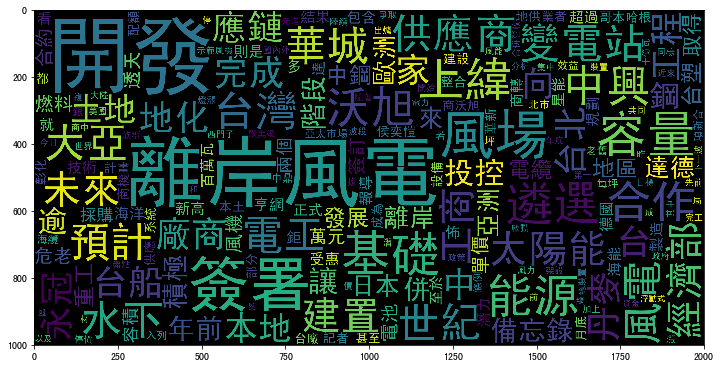

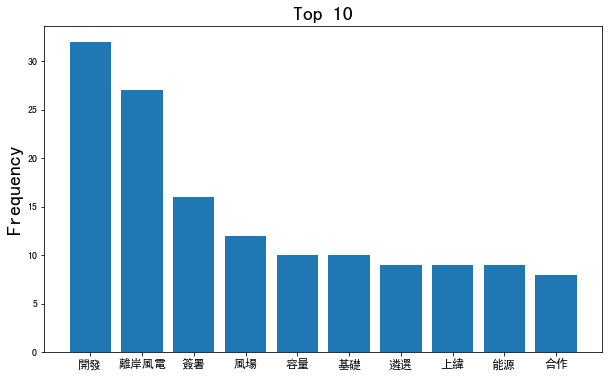

tfidf.shape:  (7, 149)
----201803291513風電遴選題材發酵.txt NEWS----
上緯 0.29110420070934484 0 0
合作 0.27941102030537357 0 41
建置 0.26150852282160103 0 72
簽署 0.24258683392445404 0 106
遴選 0.24258683392445404 0 130
風電 0.3922627842324015 0 148
----201803311513中興電 配息率達86.21％.txt NEWS----
中興電 0.40273626274914875 1 4
今年 0.23193540281694808 1 11
億元 0.5291785562472412 1 16
去年 0.2713434697135612 1 34
工商 0.46387080563389615 1 67
時報 0.46387080563389615 1 86
----201804051513風電開發商 集結台灣打前哨戰.txt NEWS----
台灣 0.3452965903156897 2 39
日本 0.20717795418941382 2 84
發展 0.20717795418941382 2 101
開發 0.3556733341498701 2 134
離岸 0.20717795418941382 2 137
離岸風電 0.40404189863107576 2 138
----201804091513離岸風電題材續航 華城、大亞、中興電股價齊創波段新高.txt NEWS----
受惠 0.21864004060741668 3 36
大亞 0.24338416804679144 3 60
建置 0.21864004060741668 3 72
成為 0.21864004060741668 3 76
經濟部 0.2803293881204874 3 110
設備 0.21864004060741668 3 124
開發 0.2502339354453587 3 134
離岸風電 0.28426363371021274 3 138
----201806261513外商啟動離岸風電在地佈局 吹響與台廠簽約號角.txt NEWS----
供應商 0.2

In [23]:
# get corpus from folder 中興電
txts_in_folder3 = get_txts(folders[3])
word_dict3 = {}
corpus3 = []

for file_name in txts_in_folder3:
    filter_list = textMining(folders[3], file_name)
    word_dict3 = get_word_dict(filter_list, word_dict3)
    join_list = " ".join(filter_list)
    corpus3.append(join_list)

plot_cloud(word_dict3)
plot_bar(word_dict3)

Y_sklearn3 = analyze(folders[3], corpus3, txts_in_folder3)

In [24]:
plot_kmeans_scatter(Y_sklearn3, txts_in_folder3)

### 分析聲寶

dict_keys(['陳盛沺', '成長', '平台', '台南', '台灣', '預計', '消費者', '昨日', '投資', '增加'])
dict_values([23, 13, 11, 9, 9, 8, 8, 7, 7, 7])


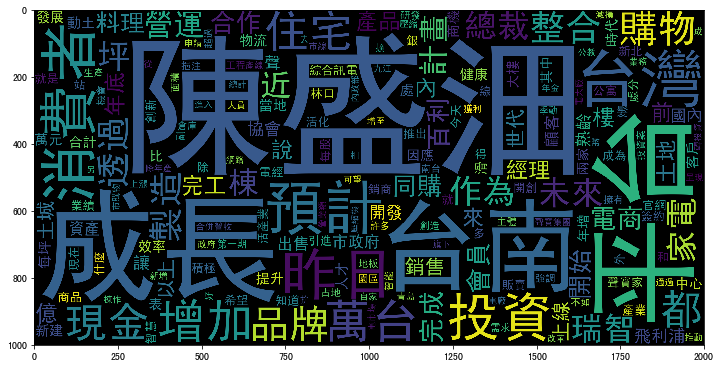

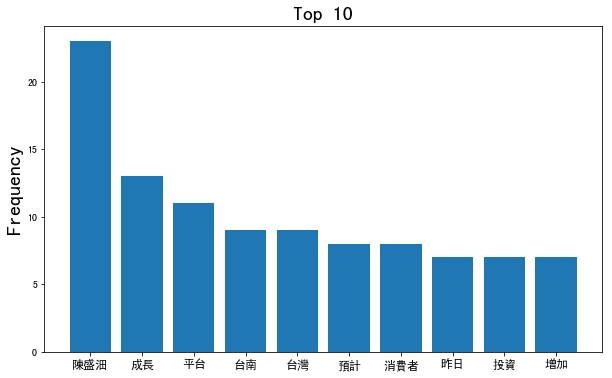

tfidf.shape:  (7, 147)
----160420180129.txt NEWS----
台南 0.5766834827377865 0 32
投資 0.41191677338413324 0 67
----160420180203.txt NEWS----
今年 0.5775646674501907 1 7
去年 0.420047030872866 1 28
增加 0.24190465651771537 1 46
聲寶 0.24292618385443523 1 115
----160420180321.txt NEWS----
世代 0.23558695390828704 2 1
今年 0.23311023348534907 2 7
平台 0.3356198640712763 2 59
成長 0.46622046697069813 2 66
整合 0.26849589125702106 2 78
----160420180326.txt NEWS----
健康 0.2230428546623805 3 14
台灣 0.3310470151150252 3 33
商機 0.2230428546623805 3 39
熟齡 0.33456428199357074 3 96
產業 0.2230428546623805 3 104
發展 0.2230428546623805 3 107
開創 0.2230428546623805 3 135
----160420180518.txt NEWS----
公司 0.29536515768804095 4 20
合作 0.22680065727989696 4 34
提供 0.29536515768804095 4 72
消費者 0.22680065727989696 4 95
簽約 0.2653362812757559 4 110
開始 0.3980044219136339 4 136
顧客 0.2653362812757559 4 145
----160420180621.txt NEWS----
住宅 0.2118761520064091 5 10
出售 0.2141272672189927 5 24
去年 0.2118761520064091 5 28
土地 0.2141272672189927 5 4

In [25]:
# get corpus from folder 聲寶
txts_in_folder4 = get_txts(folders[4])
word_dict4 = {}
corpus4 = []

for file_name in txts_in_folder4:
    filter_list = textMining(folders[4], file_name)
    word_dict4 = get_word_dict(filter_list, word_dict4)
    join_list = " ".join(filter_list)
    corpus4.append(join_list)

plot_cloud(word_dict4)
plot_bar(word_dict4)

Y_sklearn4 = analyze(folders[4], corpus4, txts_in_folder4)

In [26]:
plot_kmeans_scatter(Y_sklearn4, txts_in_folder4)

### 分析東元 

dict_keys(['馬達', '邱純枝', '董事長', '合作', '台灣', '成長', '智慧', '離岸風電', '開發', '製造'])
dict_values([149, 96, 77, 66, 60, 60, 50, 49, 47, 47])


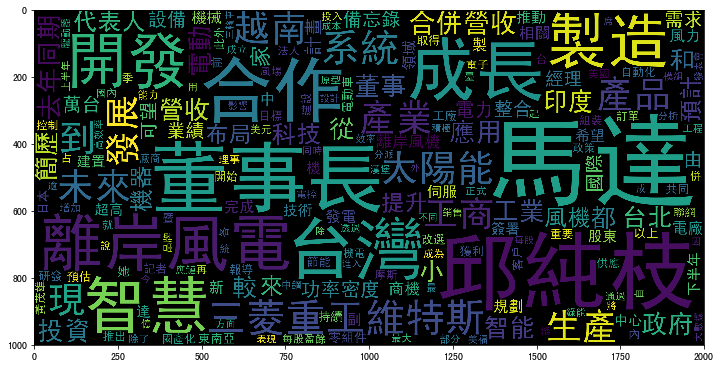

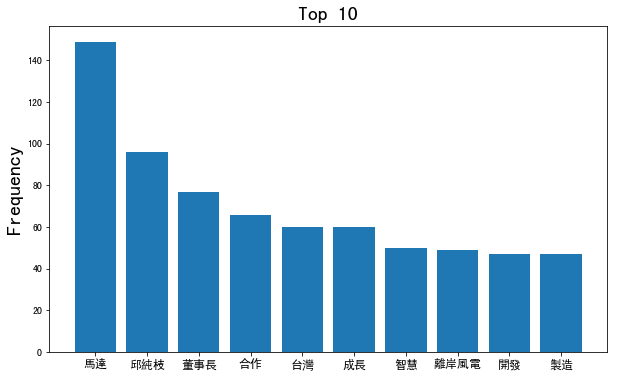

tfidf.shape:  (37, 105)
----20180110.txt NEWS----
去年 0.4643988080864487 0 12
效率 0.32431652605851097 0 49
營收 0.5952960193562552 0 60
發電 0.2976480096781276 0 65
----20180118.txt NEWS----
太陽能 0.7184257532650448 1 25
建置 0.41052900186573993 1 33
綠能 0.20526450093286996 1 75
----20180125.txt NEWS----
工業 0.3056613828689828 2 29
市場 0.22152048069189506 2 30
希望 0.3302976252035096 2 32
推出 0.412872031504387 2 43
提供 0.22104925182059398 2 45
產業 0.2750398406350506 2 63
製造 0.22104925182059398 2 81
透過 0.26991859903720866 2 88
需求 0.2292460371517371 2 99
領域 0.2292460371517371 2 102
----20180220.txt NEWS----
主要 0.5082365763095416 3 1
布局 0.5287795155334365 3 31
相關 0.4718423925076823 3 68
領域 0.48933890412065734 3 102
----20180227.txt NEWS----
企業 0.5832937117812887 4 4
東元電機 0.3544001880564301 4 57
相關 0.3328276279401698 4 68
記者 0.40640882660575645 4 84
----20180301.txt NEWS----
公司 0.22731650991884458 5 7
可以 0.2109390081285087 5 14
太陽能 0.5978217487644428 5 25
投資 0.22880452325651912 5 40
政府 0.20309569969052427 5

In [27]:
# get corpus from folder 東元
txts_in_folder5 = get_txts(folders[5])
word_dict5 = {}
corpus5 = []

for file_name in txts_in_folder5:
    filter_list = textMining(folders[5], file_name)
    word_dict5 = get_word_dict(filter_list, word_dict5)
    join_list = " ".join(filter_list)
    corpus5.append(join_list)

plot_cloud(word_dict5)
plot_bar(word_dict5)

Y_sklearn5 = analyze(folders[5], corpus5, txts_in_folder5)

In [28]:
plot_kmeans_scatter(Y_sklearn5, txts_in_folder5)

### 分析永大 

dict_keys(['許作名', '關係人', '處分', '公告', '股東', '董事會', '相對', '財務報表', '人民', '取得'])
dict_values([21, 18, 17, 15, 15, 12, 10, 10, 9, 9])


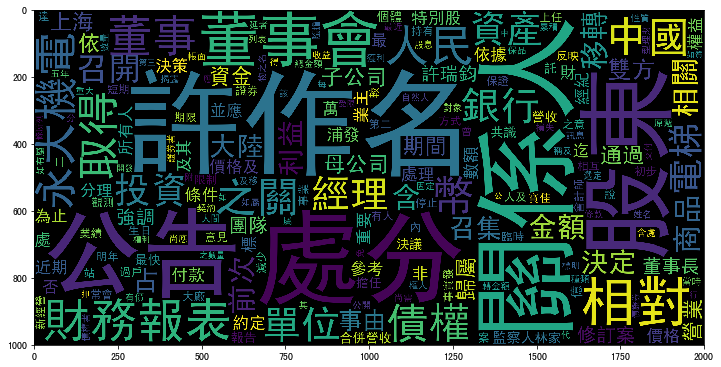

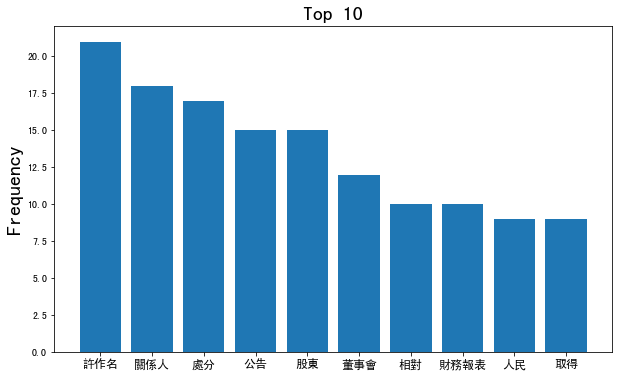

tfidf.shape:  (10, 200)
----201801141507代重要子公司永大(中國)公告取得理財商品.txt NEWS----
交易 0.5668495283176556 0 11
本次 0.2519331236967358 0 106
處分 0.2204117130463007 0 167
適用 0.2204117130463007 0 188
關係人 0.2834247641588278 0 195
----201801311507永大 比價效應突破季線.txt NEWS----
去年 0.39816438144474553 1 41
合併營收 0.2654429209631637 1 49
大廠 0.30340431239871424 1 59
大陸 0.45510646859807136 1 60
市場 0.39816438144474553 1 71
永大 0.2609669300041728 1 120
電梯 0.39816438144474553 1 199
----2018021215071月合併營收15億元 年增5.89%.txt NEWS----
仟元 0.4014703383291162 2 16
億元 0.35123910548148746 2 26
公告 0.2804421591045667 2 29
合併營收 0.35123910548148746 2 49
單位 0.35123910548148746 2 55
永大機電 0.624553468632084 2 123
----2018031215072月營收12億5840萬元，月增率-16.10%.txt NEWS----
永大 0.5933865930354364 3 120
永大機電 0.8049176052278876 3 123
----201803151507永大機電董事會決議召開107年股東常會相關事宜.txt NEWS----
事項 0.22821374895898708 4 8
召開 0.29339698074719445 4 47
年度 0.29339698074719445 4 73
日期 0.25668768830471783 4 98
決議 0.22004773556039584 4 126
股東 0.5867939614943889 4 1

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [29]:
# get corpus from folder 永大
txts_in_folder6 = get_txts(folders[6])
word_dict6 = {}
corpus6 = []

for file_name in txts_in_folder6:
    filter_list = textMining(folders[6], file_name)
    word_dict6 = get_word_dict(filter_list, word_dict6)
    join_list = " ".join(filter_list)
    corpus6.append(join_list)

plot_cloud(word_dict6)
plot_bar(word_dict6)

Y_sklearn6 = analyze(folders[6], corpus6, txts_in_folder6)

In [30]:
plot_kmeans_scatter(Y_sklearn6, txts_in_folder6)

### 分析亞力 

dict_keys(['股價', '季線', '族群', '台股', '操作', '投資', '選股', '楊基政', '震盪', '離岸風電'])
dict_values([6, 5, 5, 4, 4, 4, 3, 3, 3, 3])


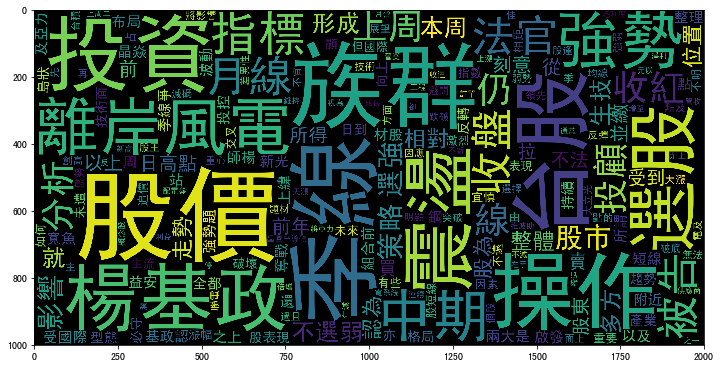

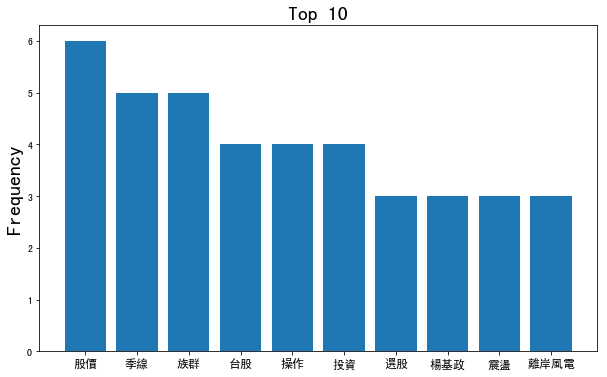

tfidf.shape:  (3, 261)
----151420180401.txt NEWS----
台股 0.22518896256638243 0 64
季線 0.28148620320797807 0 85
族群 0.28148620320797807 0 139
而言 0.22518896256638243 0 200
----151420180408.txt NEWS----
亞力 0.2081599413924259 1 20
以上 0.2081599413924259 1 24
億元 0.6244798241772778 1 38
前年 0.2081599413924259 1 51
----151420180426.txt NEWS----
投資 0.20003249990719948 2 119
法官 0.26301869885737256 2 161
被告 0.26301869885737256 2 214


In [31]:
# get corpus from folder 亞力
txts_in_folder7 = get_txts(folders[7])
word_dict7 = {}
corpus7 = []

for file_name in txts_in_folder7:
    filter_list = textMining(folders[7], file_name)
    word_dict7 = get_word_dict(filter_list, word_dict7)
    join_list = " ".join(filter_list)
    corpus7.append(join_list)

plot_cloud(word_dict7)
plot_bar(word_dict7)

Y_sklearn7 = analyze(folders[7], corpus7, txts_in_folder7)

In [32]:
plot_kmeans_scatter(Y_sklearn7, txts_in_folder7)

In [33]:
def analyze1(comapny, corpus, txts_all):
    # tfidf
    vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 0.2)
    tfidf = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    print("tfidf.shape: ", tfidf.shape)
    for i in range(len(corpus)):
        print('----{0} NEWS----'.format(txts_all[i]), comapny[i])
        for j in range(len(words)):
            if words[j] in imp_words:
                tfidf[i,j] = tfidf[i,j] * 2
            if tfidf[i,j] > 0.2:
                print(words[j], tfidf[i,j], i ,j)
    
    X = tfidf.toarray()
    sklearn_pca = PCA(n_components = 2)
    Y_sklearn = sklearn_pca.fit_transform(X)
    
    return Y_sklearn

In [34]:
all_corpus = []
company_names = []
texts_all = []

for i in range(len(folders)):
    corpus = eval("corpus" + str(i))
    names = [folders[i]] * len(corpus)
    all_corpus += corpus
    company_names += names
    texts_all += eval("txts_in_folder" + str(i))

Y_sklearn_all = analyze1(company_names, all_corpus, texts_all)

tfidf.shape:  (97, 61)
----20170303_1611_投保中心受理中電求償登記.txt NEWS---- 中電/
市場 0.8593126575841763 0 20
指出 0.39472405318640247 0 25
相關 0.27214506868168553 0 40
----20170327_1611_中電董事會決議出售台南樹谷廠土地.txt NEWS---- 中電/
億元 0.5462407194428791 1 2
去年 0.2698058284724956 1 7
董事會 1.1778889135596766 1 47
通過 0.3789310522542974 1 54
----20170412_1611_中電參加台灣科技展.txt NEWS---- 中電/
政府 0.2914413322611344 2 29
智慧 0.7043733864477115 2 31
系統 0.5543591278732667 2 43
----20170628_1611_現任董座周麗真續掌中電經營權.txt NEWS---- 中電/
今年 0.2482910830801065 3 0
董事 0.7846075983477651 3 46
董事長 0.36246320248909375 3 48
----20170628_1611_電纜股市場派遭解任.txt NEWS---- 中電/
億元 0.2218541867642879 4 2
市場 0.3790253312662512 4 20
政府 0.2052024255859332 4 29
時報 0.2052024255859332 4 30
智慧 0.2975675268072267 4 31
節能 0.3189309251581455 4 42
董事 0.30780363837889985 4 46
通過 0.30780363837889985 4 54
----20170830_1611_中電與投保中心和解.txt NEWS---- 中電/
今年 0.3923968323718429 5 0
億元 0.6620289649146477 5 2
政府 0.3674033419607251 5 29
----20180329_1611_中電去年轉虧為盈.txt NEWS---- 中電/

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



 0.5187003785487039 56 34
產品 0.27461266141741164 56 36
發展 0.2873686483955042 56 38
製造 0.31740578963193367 56 50
----20180327.txt NEWS---- 東元/
智慧 0.7002336724353153 57 31
東元 0.5521112067726373 57 34
系統 0.28703180803692036 57 43
----20180328.txt NEWS---- 東元/
市場 0.24033380734481574 58 20
東元 0.649178741613186 58 34
東元電機 0.3144712272960824 58 35
馬達 0.46345690669363165 58 60
----20180329.txt NEWS---- 東元/
台灣 0.2909927060598724 59 11
市場 0.5819854121197447 59 20
推動 0.4157053945615736 59 26
東元 0.32750677211829815 59 34
產業 0.3686305759729881 59 37
馬達 0.4008192394417289 59 60
----20180421.txt NEWS---- 東元/
今年 0.2711671768569627 60 0
可望 0.40197151868261716 60 9
合併營收 0.3875771652314673 60 13
市場 0.28137902829915235 60 20
東元 0.4750301401768359 60 34
預估 0.20098575934130858 60 58
----20180423.txt NEWS---- 東元/
億元 0.30687625189768597 61 2
全球 0.5580578118480141 61 3
提供 0.27902890592400703 61 27
智能 0.299590085276874 61 32
東元 0.47205440714165003 61 34
產品 0.24991714376937743 61 36
----20180425-2.txt NEWS---- 東

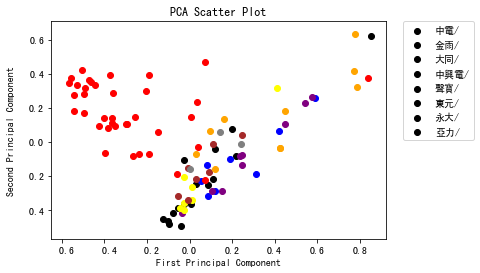

In [35]:
colors = ['black', 'blue', 'purple', 'yellow', 'brown', 'red', 'orange', 'gray', 'lime', 'cyan']
#    ["中電/", "金雨/", "大同/", "中興電/", "聲寶/", "東元/", "永大/", "亞力/"]

for i in range(len(folders)):
    for index in range(len(company_names)):
        if company_names[index] == folders[i]:
            x = Y_sklearn_all[:, 0][index]
            y = Y_sklearn_all[:, 1][index]
            plt.scatter(x, y, c=colors[i])

plt.legend(folders , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()